In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [9]:
# Set image size
IMG_HEIGHT, IMG_WIDTH = 128, 128

In [10]:
# Define your dataset path
dataset_path = r'C:\Users\HP\Plant disese detection\Plantvillage\Plantvillage'

In [12]:
# Get class labels (folder names)
class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)
print(f"Classes found: {class_names}")


Classes found: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [13]:
# Preprocessing function
data = []
labels = []

In [14]:
print("Loading and preprocessing images...")
for label_index, class_folder in enumerate(class_names):
    folder_path = os.path.join(dataset_path, class_folder)
    image_files = os.listdir(folder_path)

    for image_file in tqdm(image_files, desc=f"Processing {class_folder}"):
        try:
            img_path = os.path.join(folder_path, image_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # MobileNetV2 uses RGB
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            data.append(img / 255.0)
            labels.append(label_index)
        except Exception as e:
            print(f"Error loading {image_file}: {e}")

Loading and preprocessing images...


Processing Tomato_Septoria_leaf_spot: 100%|████████████████████████████████████████| 1771/1771 [00:17<00:00, 98.95it/s]
Processing Tomato_Spider_mites_Two_spotted_spider_mite: 100%|█████████████████████| 1676/1676 [00:14<00:00, 119.27it/s]
Processing Tomato__Tomato_YellowLeaf__Curl_Virus: 100%|███████████████████████████| 3209/3209 [00:28<00:00, 113.75it/s]


Error loading svn-r6Yb5c: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



Processing Tomato_healthy: 100%|███████████████████████████████████████████████████| 1591/1591 [00:16<00:00, 97.62it/s]


In [15]:

data = np.array(data, dtype=np.float32)
labels = np.array(labels)

In [16]:
# Visualize some samples from each class
def visualize_samples(data, labels, class_names):
    plt.figure(figsize=(12, 8))
    for class_id in range(min(10, num_classes)):
        idx = np.where(labels == class_id)[0][0]
        plt.subplot(2, 5, class_id + 1)
        plt.imshow(data[idx])
        plt.title(class_names[class_id])
        plt.axis("off")
    plt.suptitle("Sample Images from Dataset")
    plt.show()

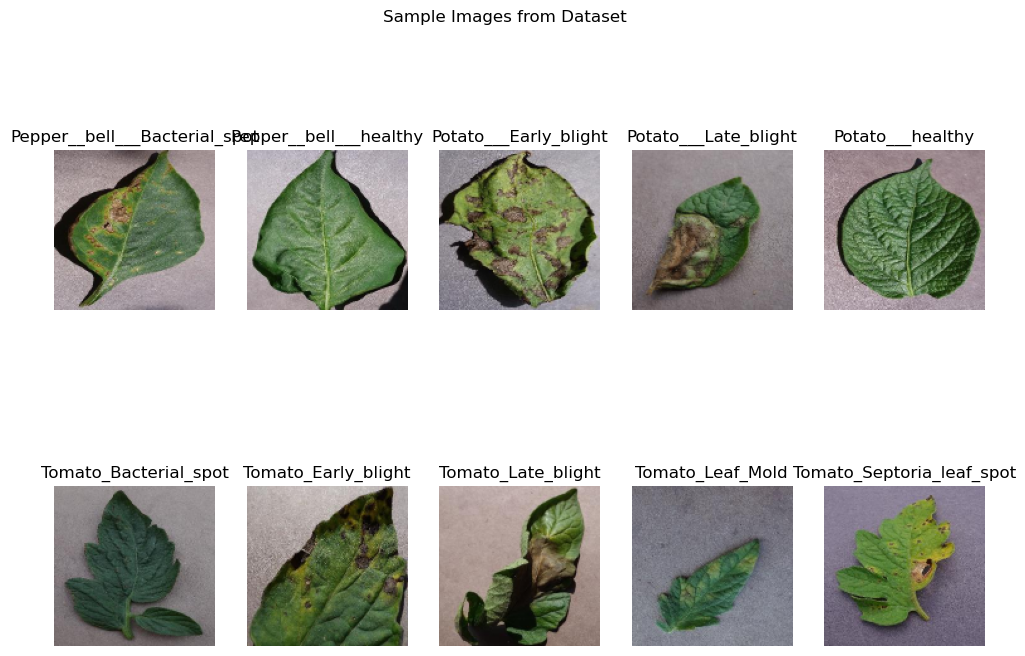

In [17]:
visualize_samples(data, labels, class_names)

In [18]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [19]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [20]:
# Load MobileNetV2 without top layer
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base model

In [21]:
# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 137s 251ms/step - accuracy: 0.5682 - loss: 1.3920 - val_accuracy: 0.8389 - val_loss: 0.4759
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 113s 220ms/step - accuracy: 0.8107 - loss: 0.5880 - val_accuracy: 0.8874 - val_loss: 0.3465
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 118s 229ms/step - accuracy: 0.8405 - loss: 0.4721 - val_accuracy: 0.8854 - val_loss: 0.3380
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 124s 241ms/step - accuracy: 0.8662 - loss: 0.4020 - val_accuracy: 0.9002 - val_loss: 0.3008
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 112s 217ms/step - accuracy: 0.8779 - loss: 0.3569 - val_accuracy: 0.8949 - val_loss: 0.3179
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 113s 218ms/step - accuracy: 0.8937 - loss: 0.3194 - val_accuracy: 0.9079 - val_loss: 0.2729
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 109s 211ms/step - accuracy: 0.8956 - loss: 0.3023 - val_accuracy: 0.9058 - val_loss: 0.2770
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 109s 211ms/step - accuracy: 0.9057 -

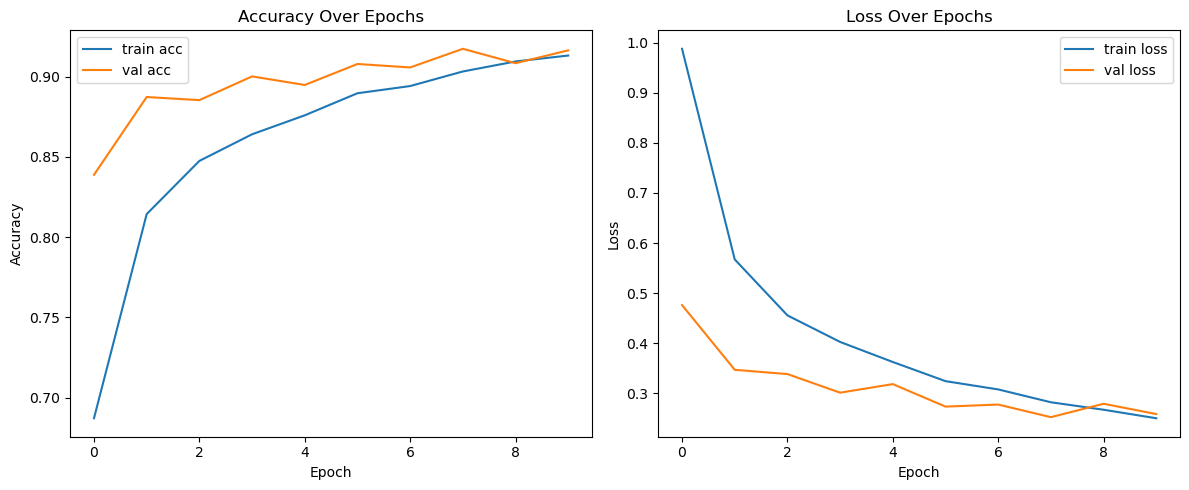

In [25]:
# Visualize accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [26]:
# Save the model in HDF5 format
model.save("plant_disease_mobilenetv2.h5")

print("✅ Model saved as 'plant_disease_mobilenetv2.h5'")


✅ Model saved as 'plant_disease_mobilenetv2.h5'
